In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as scs
import scipy.linalg as spla

import koma.oma
import koma.plot
import koma.clustering

In [2]:
# Daytime recording

parquet_file = r'./data/data_synced.parquet'
df = pd.read_parquet(parquet_file)

df_filtered_day = df.drop(['T1E_x', 'T1E_y', 'T1E_z'], axis=1)

df_filtered_day = df.drop(['T1E_x', 'T1E_y', 'T1E_z'], axis=1)
df_filtered_day = df_filtered_day.drop(df.index[0:16*9*3600+30000])
df_filtered_day = df_filtered_day.drop(df.index[-1])
df_filtered_day = df_filtered_day.drop(df.index[16*10*3600:-1])
df_filtered_day.shape

(27600, 57)

In [3]:
# Nighttime recording

parquet_file = r'./data/data_synced.parquet'
df = pd.read_parquet(parquet_file)

df_filtered_night = df.drop(['G1E_x', 'G1E_y', 'G1E_z', 'G9W_x', 'G9W_y', 
                       'G9W_z', 'T1E_x', 'T1E_y', 'T1E_z', 'T1W_x', 'T1W_y', 'T1W_z'], axis=1)

df_filtered_night = df_filtered_night.drop(df.index[:16*1*1875])
df_filtered_night = df_filtered_night.drop(df.index[16*1*3600:])
df_filtered_night.shape

(27600, 48)

In [4]:
# Detrending

acceleration_data_day = df_filtered_day.to_numpy()
acceleration_data_night = df_filtered_night.to_numpy()

fs = 16
t_day = np.arange(0, len(acceleration_data_day))
t_s_day = t_day / fs

t_night = np.arange(0, len(acceleration_data_night))
t_s_night = t_night / fs

acceleration_data_day = scs.detrend(acceleration_data_day, axis=0)
acceleration_data_night = scs.detrend(acceleration_data_night, axis=0)

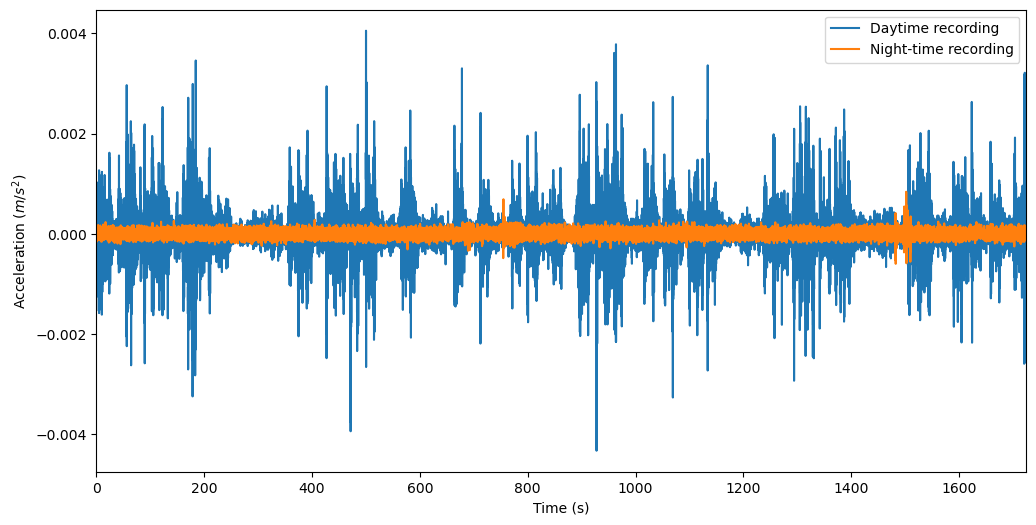

In [5]:
plt.figure(figsize=(12,6))
plt.plot(t_s_day, acceleration_data_day[:,0], label="Daytime recording")
plt.plot(t_s_night, acceleration_data_night[:,0], label="Night-time recording")
plt.xlim(0, t_s_day[-1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration ($m/s^2$)")
plt.legend(loc="upper right")

# plt.savefig("./pictures/day_night_recording.svg")
plt.show()

In [6]:
# Establishing cross-spectral density matrix

nperseg = 1000
zp = 8
nfft =  nperseg * zp

Sxy = np.array([[scs.csd(ch1, ch2, fs, nperseg=nperseg, nfft=nfft)[1] for ch1 in acceleration_data_day.T] 
                for ch2 in acceleration_data_day.T])
Sxx = np.trace(Sxy)
f, _ = scs.welch(acceleration_data_day[:,0], fs=fs, nperseg=nperseg, nfft=nfft)


w = np.linspace(0, fs/2, Sxy.shape[2])
n = acceleration_data_day.shape[1]
singular_values = np.zeros((n, len(w)))
singular_vector = np.zeros((n, len(w)), dtype=complex)

# Singular value decomposition for plot background

for k in range(len(w)):
    U, S, V = spla.svd(Sxy[..., k])

    singular_values[:, k] = S[0:n]
    singular_vector[:, k] = U[:,0]

In [7]:
# CoV-SSI

i = 200
order = np.arange(2, 62, 2)
fs = 16

lambd, phi, orders = koma.oma.covssi(acceleration_data_day, fs, i, order, return_flat=True)

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


In [8]:
# Stabilisation

stabcrit = {'freq':0.05, 'damping':0.2, 'mac':0.1}
s = 2
valid_range = {'freq':[0, np.inf], 'damping':[0, 0.3], 'mpc':[0.6, 1]}

lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, valid_range=valid_range, indicator='freq', use_legacy=False)

c:\Users\marku\anaconda3\Lib\site-packages\koma\modal.py:272: RuntimeWarning: divide by zero encountered in scalar divide
  eta = (Syy-Sxx)/(2*Sxy)
c:\Users\marku\anaconda3\Lib\site-packages\koma\modal.py:274: RuntimeWarning: invalid value encountered in scalar multiply
  lambda1 = (Sxx+Syy)/2 + Sxy*np.sqrt(eta**2+1)
c:\Users\marku\anaconda3\Lib\site-packages\koma\modal.py:275: RuntimeWarning: invalid value encountered in scalar multiply
  lambda2 = (Sxx+Syy)/2 - Sxy*np.sqrt(eta**2+1)


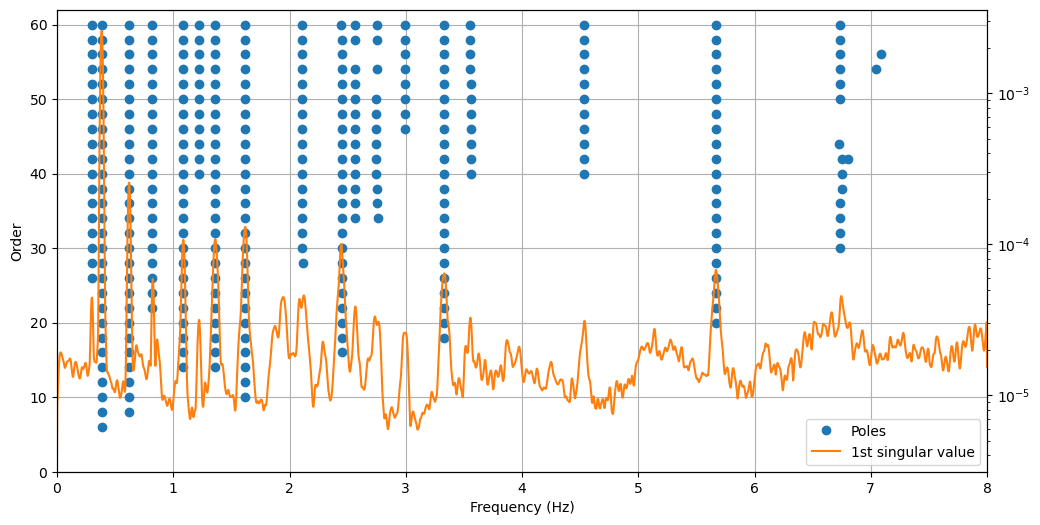

In [9]:
omega = np.abs(lambd_stab)
x = omega / (2 * np.pi)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Order")
ax1.plot(x, orders_stab, "o", label="Poles")
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 62)
ax1.grid()

ax2 = ax1.twinx()
# ax2.set_ylabel("Auto-spectral density")
ax2.plot(w, singular_values[0].real, color="C1", label="1st singular value")
ax2.set_yscale("log")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right")

# plt.savefig("./pictures/ssi_after_stab.svg")
plt.show()


In [10]:
# Automatic pole clustering

pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=6, min_samples=6,
                                               scaling={'mac':0.4, 'omega_n':0.8}, normalize_distances=False)

prob_threshold = 1.0

pole_clusterer.cluster()

outputs = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)
lambd_used, phi_used, orders_stab_used, group_ixs, all_single_ix, probs = outputs

xi_auto, omega_n_auto, phi_auto, order_auto, ixs_auto, probs_auto = koma.clustering.group_clusters(*outputs)

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi
xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)
phi_mean = np.vstack([np.mean(phi_i, axis=1) for phi_i in grouped_phis]).T

In [11]:
print(fn_mean)
print(fn_mean.shape)


[0.29987586 0.38392749 0.38392754 0.61968128 0.61968229 0.82024069
 1.08754663 1.08755389 1.22047111 1.36068997 1.61720239 1.61746796
 2.11060634 2.11133213 2.44782999 2.56056514 2.74534385 2.99185436
 3.32954725 3.5572917  4.53543204 5.66778399 5.66796765 6.74479926]
(24,)


In [20]:
fn_mean_no_dupes = np.delete(fn_mean, (2, 4, 7, 11, 13, 22))
phi_mean_no_dupes = np.delete(phi_mean, (2, 4, 7, 11, 13, 22), axis=1)

In [13]:
fn_mean_2 = np.delete(fn_mean, (2, 4, 7, 11, 13, 15, 21, 22, 23))
# fn_mean_2 = np.delete(fn_mean, (2, 4, 7, 11, 13, 22))
# print(fn_mean_2.shape)

phi_mean_2 = np.delete(phi_mean, [2, 4, 7, 11, 13, 15, 21, 22, 23], axis=1)
# phi_mean_2 = np.delete(phi_mean, [2, 4, 7, 11, 13, 22], axis=1)
# print(phi_mean_2.shape)

xi_mean_2 = np.delete(xi_mean, [2, 4, 7, 11, 13, 15, 21, 22, 23])

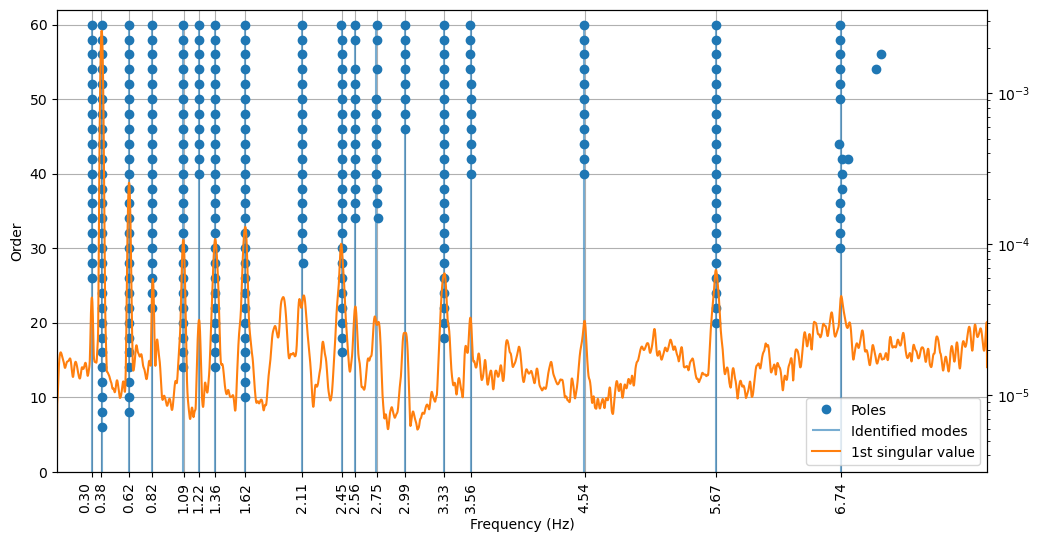

In [14]:
omega = np.abs(lambd_stab)
x = omega / (2 * np.pi)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Order")
ax1.plot(x, orders_stab, "o", label="Poles")
ax1.vlines(fn_mean_no_dupes, 0, 60, alpha=0.6, label="Identified modes")
ax1.set_xticks(np.round(fn_mean_no_dupes, 2))
ticklabels = ax1.get_xticklabels()
ticklabels[0].set_ha("right")
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 62)
ax1.grid()

ax2 = ax1.twinx()
# ax2.set_ylabel("Auto-spectral density")
ax2.plot(w, singular_values[0].real, color="C1", label="1st singular value")
ax2.set_yscale("log")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right")

plt.setp(ax1.get_xticklabels(), rotation=90)

# plt.savefig("./pictures/auto_ssi_before_mmi.svg")
plt.show()


In [15]:
indexed_freq_ssi = np.zeros((len(fn_mean_2), 2))
indexed_freq_ssi[:,0] = np.array([i for i in range(1, len(fn_mean_2) + 1)])
indexed_freq_ssi[:,1] = fn_mean_2
indexed_freq_ssi

array([[ 1.        ,  0.29987586],
       [ 2.        ,  0.38392749],
       [ 3.        ,  0.61968128],
       [ 4.        ,  0.82024069],
       [ 5.        ,  1.08754663],
       [ 6.        ,  1.22047111],
       [ 7.        ,  1.36068997],
       [ 8.        ,  1.61720239],
       [ 9.        ,  2.11060634],
       [10.        ,  2.44782999],
       [11.        ,  2.74534385],
       [12.        ,  2.99185436],
       [13.        ,  3.32954725],
       [14.        ,  3.5572917 ],
       [15.        ,  4.53543204]])

In [16]:
t1w = phi_mean_2[54:, :]
phi_mean_2 = np.append(phi_mean_2, t1w, 0)

ind = np.array([
    16.1, 16.2, 16.3,
    15.1, 15.2, 15.3,
    9.1,  9.2,  9.3,
    3.1,  3.2,  3.3,
    10.1, 10.2, 10.3,
    4.1,  4.2,  4.3,
    11.1, 11.2, 11.3,
    5.1,  5.2,  5.3,
    12.1, 12.2, 12.3,
    6.1,  6.2,  6.3,
    13.1, 13.2, 13.3,
    7.1,  7.2,  7.3,
    14.1, 14.2, 14.3,
    8.1,  8.2,  8.3,
    19.1, 19.2, 19.3,
    17.1, 17.2, 17.3,
    20.1, 20.2, 20.3,
    18.1, 18.2, 18.3,
    1.1,  1.2,  1.3,
    2.1,  2.2,  2.3,
])

In [17]:
indexed_modes_ssi = np.zeros((60, fn_mean_2.shape[0] + 1))

indexed_modes_ssi[:,0] = ind
indexed_modes_ssi[:,1:] = phi_mean_2.real

indexed_modes_ssi = indexed_modes_ssi[indexed_modes_ssi[:, 0].argsort()]

In [18]:
ordered_modes_ssi = indexed_modes_ssi[:, 1:]
ordered_modes_ssi.shape

(60, 15)

In [21]:
phi_csv = phi_mean_no_dupes[:57,:]
phi_csv.shape

(57, 18)

In [22]:
# Exporting .npy files for model updating
np.save("results/model updating/grenland_bridge_frequencies.npy", indexed_freq_ssi)
np.savetxt("results/model updating/grenland_bridge_frequencies.txt", indexed_freq_ssi)
np.save("results/model updating/grenland_bridge_modes.npy", ordered_modes_ssi)
np.savetxt("results/model updating/grenland_bridge_modes.txt", ordered_modes_ssi)

In [23]:
# Exporting .csv files for dynamo
df_freq = pd.DataFrame(fn_mean_2)
df_freq.to_csv("./results/dynamo/ssi_freq.csv", index=False, header=False, float_format='%.13f')

df_modes = pd.DataFrame(phi_csv.real)
df_modes.to_csv('./results/dynamo/ssi_modes.csv', index=False, header=False, float_format='%.13f')


In [24]:
# Exporting .csv files for dynamo
df_freq = pd.DataFrame(fn_mean_no_dupes)
df_freq.to_csv("./results/dynamo/ssi_freq_before_mmi.csv", index=False, header=False, float_format='%.13f')

df_modes = pd.DataFrame(phi_csv.real)
df_modes.to_csv('./results/dynamo/ssi_modes_before_mmi.csv', index=False, header=False, float_format='%.13f')

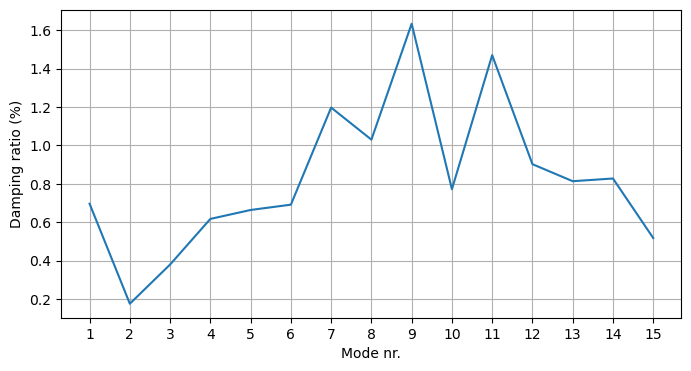

In [27]:
np.save("./results/damping_ratio.npy", xi_mean_2)


plt.figure(figsize=(8,4))
plt.grid()
plt.xticks(np.arange(15)+1)
plt.xlabel("Mode nr.")
plt.ylabel("Damping ratio (%)")
plt.plot(np.arange(15)+1, xi_mean_2*100)

# plt.savefig("./pictures/damping_ratios.svg")
plt.show()

In [26]:
fdd_freq = np.load("results/mmi/grenland_bridge_frequencies.npy")
fdd_freq = fdd_freq[:,1]

num_freq = np.array([0.28526074, 0.39649591, 0.70043784, 0.93709868, 1.37221301,
       1.29912007, 1.68370318, 1.89175594, 2.20303798, 2.60153604,
       2.76451707, 3.52018142, 4.29300928, 3.71072459, 5.94783735])
fdd_freq_2 = np.delete(fdd_freq, (8, 9, 11, 13, 18, 19, 20, 22, 23, 24, 25))
modes = np.array([i+1 for i in range(len(fn_mean_2))])
diff = np.abs(fn_mean_2 - fdd_freq_2) / fn_mean_2 * 100

columns = np.array([modes, num_freq, fn_mean_2, fdd_freq_2, xi_mean_2*100])
column_names = ["Mode", "Numerical model", "SSI", "FDD", "Damping ratio [%]"]

fdd_ssi_table = pd.DataFrame(columns.T, columns=column_names)
fdd_ssi_table["Mode"] = fdd_ssi_table["Mode"].astype(int)

print(fdd_ssi_table.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{rrrrr}
\toprule
Mode & Numerical model & SSI & FDD & Damping ratio [%] \\
\midrule
1 & 0.2853 & 0.2999 & 0.2980 & 0.6960 \\
2 & 0.3965 & 0.3839 & 0.3840 & 0.1751 \\
3 & 0.7004 & 0.6197 & 0.6200 & 0.3793 \\
4 & 0.9371 & 0.8202 & 0.8220 & 0.6168 \\
5 & 1.3722 & 1.0875 & 1.0860 & 0.6633 \\
6 & 1.2991 & 1.2205 & 1.2200 & 0.6910 \\
7 & 1.6837 & 1.3607 & 1.3600 & 1.1968 \\
8 & 1.8918 & 1.6172 & 1.6180 & 1.0296 \\
9 & 2.2030 & 2.1106 & 2.1180 & 1.6335 \\
10 & 2.6015 & 2.4478 & 2.4460 & 0.7716 \\
11 & 2.7645 & 2.7453 & 2.7340 & 1.4698 \\
12 & 3.5202 & 2.9919 & 2.9940 & 0.9019 \\
13 & 4.2930 & 3.3295 & 3.3320 & 0.8132 \\
14 & 3.7107 & 3.5573 & 3.5560 & 0.8273 \\
15 & 5.9478 & 4.5354 & 4.5400 & 0.5174 \\
\bottomrule
\end{tabular}

